In [1]:
import pandas as pd
import numpy as np
import cv2
import os
import pickle
import zipfile
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline

from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Dense,Dropout,Flatten,Conv2D,MaxPooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

In [2]:
zip_file = zipfile.ZipFile("/content/drive/MyDrive/OpenCV_Projects/myData_Number.zip","r")
zip_file.extractall()
zip_file.close()

In [3]:
path = "/content/myData"
testRatio = 0.2
valRatio = 0.2
imageDimensions = (32,32,3)
batchSizeVal = 50
epochsVal = 15
stepsPerEpochVal = 100

In [4]:
count = 0
images = []
classNo = []
mylist = os.listdir(path)
print("Total Classes Detected : ", len(mylist))
noOfclasses = len(mylist)
print("Importing Classes ......")
for x in range(0, noOfclasses):
    myPicList = os.listdir(path + "/" + str(x))
    for y in myPicList:
        curImg = cv2.imread(path + "/" + str(x) + "/" + y)
        curImg = cv2.resize(curImg, (32,32))
        images.append(curImg)
        classNo.append(x)
    print(x,end = " ")

print()
print("Total Images in Images List = ",len(images))
print("Total IDS in classNo List= ",len(classNo))

Total Classes Detected :  10
Importing Classes ......
0 1 2 3 4 5 6 7 8 9 
Total Images in Images List =  10160
Total IDS in classNo List=  10160


In [5]:
images = np.array(images)
classNo = np.array(classNo)
print(images.shape,classNo.shape)

(10160, 32, 32, 3) (10160,)


In [6]:
X_train,X_test,y_train,y_test = train_test_split(images,classNo,test_size = testRatio)
X_train,X_validation,y_train,y_validation = train_test_split(X_train,y_train,test_size = testRatio)

print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)
print(X_validation.shape,y_validation.shape)

(6502, 32, 32, 3) (6502,)
(2032, 32, 32, 3) (2032,)
(1626, 32, 32, 3) (1626,)


In [7]:
numOfSamples = []
for x in range(0,noOfclasses):
    numOfSamples.append(len(np.where(y_train == 0)[0]))
print(numOfSamples)

[645, 645, 645, 645, 645, 645, 645, 645, 645, 645]


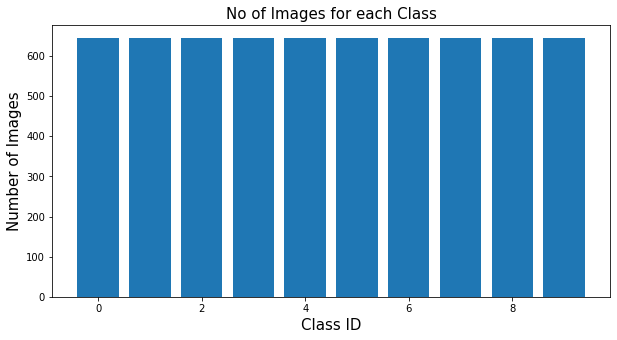

In [8]:
plt.figure(figsize=(10,5))
plt.bar(range(0,noOfclasses),numOfSamples)
plt.title("No of Images for each Class",fontsize = 15)
plt.xlabel("Class ID",fontsize = 15)
plt.ylabel("Number of Images",fontsize = 15)
plt.show()

In [9]:
def preprocessing(image):
    img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    img = cv2.equalizeHist(img)
    img = img / 255
    return img

def display_img(image):

    plt.figure(figsize = (7,7))
    plt.imshow(image,cmap = "gray")
    plt.title(f"Shape : {image.shape}")
    plt.show()

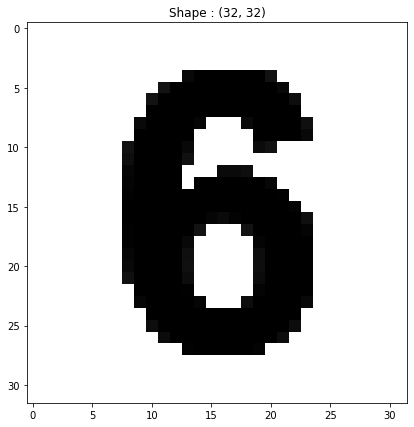

In [10]:
test_img = preprocessing(X_train[30])
test_img = cv2.resize(test_img,(32,32))

display_img(test_img)

In [11]:
X_train = np.array(list(map(preprocessing,X_train)))
X_test = np.array(list(map(preprocessing,X_test)))
X_validation = np.array(list(map(preprocessing,X_validation)))

print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)
print(X_validation.shape,y_validation.shape)

(6502, 32, 32) (6502,)
(2032, 32, 32) (2032,)
(1626, 32, 32) (1626,)


In [12]:
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1],X_train.shape[2],1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1],X_test.shape[2],1)
X_validation = X_validation.reshape(X_validation.shape[0],X_validation.shape[1],X_validation.shape[2],1)

print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)
print(X_validation.shape,y_validation.shape)

(6502, 32, 32, 1) (6502,)
(2032, 32, 32, 1) (2032,)
(1626, 32, 32, 1) (1626,)


In [13]:
dataGen = ImageDataGenerator(width_shift_range = 0.1,
                             height_shift_range = 0.1,
                             zoom_range = 0.2,
                             shear_range = 0.1,
                             rotation_range = 10)
dataGen.fit(X_train)

In [14]:
batches = dataGen.flow(X_train,y_train,batch_size = 20)
X_batches,y_batches = next(batches)

print(X_batches.shape,y_batches.shape)

(20, 32, 32, 1) (20,)


In [15]:
y_train = to_categorical(y_train, noOfclasses)
y_test = to_categorical(y_test, noOfclasses)
y_validation = to_categorical(y_validation, noOfclasses)

print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)
print(X_validation.shape,y_validation.shape)

(6502, 32, 32, 1) (6502, 10)
(2032, 32, 32, 1) (2032, 10)
(1626, 32, 32, 1) (1626, 10)


In [16]:
def myModel():

    noOfFilters = 60
    sizeOfFilter5 = (5,5)
    sizeOfFilter3 = (3,3)
    sizeOfPool = (2,2)
    noOfNodes = 500

    model = Sequential()
    model.add(Conv2D(filters = noOfFilters, kernel_size = sizeOfFilter5,input_shape = (imageDimensions[0],imageDimensions[1],1),
                     activation = "relu"))
    model.add(Conv2D(filters = noOfFilters, kernel_size = sizeOfFilter5,activation = "relu"))
    model.add(MaxPooling2D(pool_size = sizeOfPool ))
    
    model.add(Conv2D(filters = noOfFilters // 2, kernel_size = sizeOfFilter3,activation = "relu"))
    model.add(Conv2D(filters = noOfFilters // 2, kernel_size = sizeOfFilter3,activation = "relu"))
    model.add(MaxPooling2D(pool_size = sizeOfPool ))
    model.add(Dropout(rate = 0.5))

    model.add(Flatten())
    model.add(Dense(units = noOfNodes, activation = "relu"))
    model.add(Dropout(rate = 0.5))
    model.add(Dense(units = noOfclasses, activation = "softmax"))

    model.compile(Adam(learning_rate = 0.001), loss = "categorical_crossentropy",metrics = ["accuracy"])
    return model

In [17]:
model = myModel()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 60)        1560      
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 60)        90060     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 12, 12, 60)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 10, 10, 30)        16230     
                                                                 
 conv2d_3 (Conv2D)           (None, 8, 8, 30)          8130      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 4, 4, 30)         0         
 2D)                                                    

In [18]:
batchSizeVal,noOfclasses,stepsPerEpochVal,epochsVal

(50, 10, 100, 15)

In [19]:
# steps_per_epoch = n_samples / batch_size
X_train.shape[1] / batchSizeVal

0.64

In [20]:
history = model.fit_generator(dataGen.flow(X_train,y_train,batch_size = batchSizeVal),
                              steps_per_epoch = 100,
                              epochs = epochsVal,
                              validation_data = (X_validation,y_validation),
                              shuffle = 1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  """


Epoch 1/15
100/100 [==============================] - 7s 27ms/step - loss: 1.5151 - accuracy: 0.4667 - val_loss: 0.2077 - val_accuracy: 0.9410
Epoch 2/15
100/100 [==============================] - 2s 21ms/step - loss: 0.5764 - accuracy: 0.8033 - val_loss: 0.1149 - val_accuracy: 0.9662
Epoch 3/15
100/100 [==============================] - 2s 23ms/step - loss: 0.3901 - accuracy: 0.8770 - val_loss: 0.0978 - val_accuracy: 0.9680
Epoch 4/15
100/100 [==============================] - 2s 21ms/step - loss: 0.3096 - accuracy: 0.9027 - val_loss: 0.0611 - val_accuracy: 0.9809
Epoch 5/15
100/100 [==============================] - 2s 21ms/step - loss: 0.2510 - accuracy: 0.9218 - val_loss: 0.0574 - val_accuracy: 0.9803
Epoch 6/15
100/100 [==============================] - 2s 22ms/step - loss: 0.1968 - accuracy: 0.9360 - val_loss: 0.0490 - val_accuracy: 0.9791
Epoch 7/15
100/100 [==============================] - 2s 21ms/step - loss: 0.1753 - accuracy: 0.9465 - val_loss: 0.0587 - val_accuracy: 0.9815

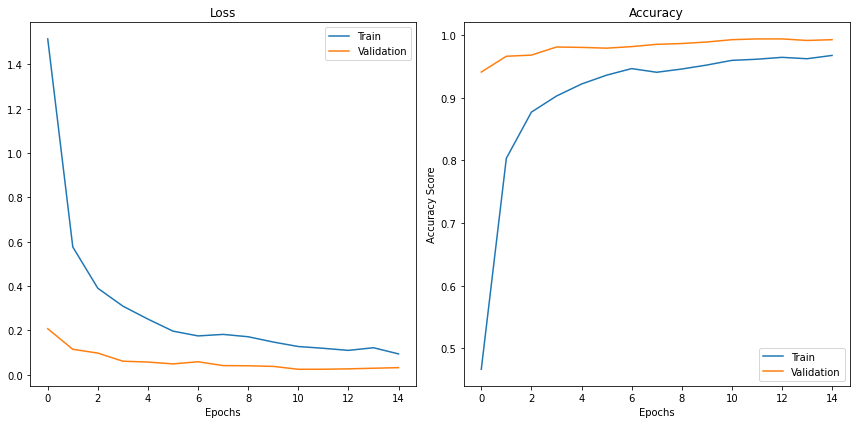

In [21]:
plt.figure(figsize = (12,6))

plt.subplot(1,2,1)
plt.plot(history.history['loss'],label = "Train")
plt.plot(history.history['val_loss'], label = "Validation")
plt.legend(loc = "best")
plt.title('Loss')
plt.xlabel('Epochs')

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'],label = "Train")
plt.plot(history.history['val_accuracy'],label = "Validation")
plt.legend(loc = "best")
plt.title('Accuracy')
plt.ylabel("Accuracy Score")
plt.xlabel('Epochs')

plt.tight_layout()
plt.show()

In [22]:
score = model.evaluate(X_test,y_test,verbose = 0)
print('Test Score = ',score[0])
print('Test Accuracy =', score[1])

Test Score =  0.029915127903223038
Test Accuracy = 0.9916338324546814


In [23]:
pickle_out = open("digits_model_trained.p","wb")
pickle.dump(model,pickle_out)
pickle_out.close()

INFO:tensorflow:Assets written to: ram://82cd73ee-71c8-432d-9838-2e7e7c275127/assets


In [25]:
model.save("digits_model.h5")
model.save_weights("digits_model_weights.h5")

---

In [4]:
imageDimensions = (32,32,3)
noOfclasses = 10

def myModel():

    noOfFilters = 60
    sizeOfFilter5 = (5,5)
    sizeOfFilter3 = (3,3)
    sizeOfPool = (2,2)
    noOfNodes = 500

    model = Sequential()
    model.add(Conv2D(filters = noOfFilters, kernel_size = sizeOfFilter5,input_shape = (imageDimensions[0],imageDimensions[1],1),
                     activation = "relu"))
    model.add(Conv2D(filters = noOfFilters, kernel_size = sizeOfFilter5,activation = "relu"))
    model.add(MaxPooling2D(pool_size = sizeOfPool ))
    
    model.add(Conv2D(filters = noOfFilters // 2, kernel_size = sizeOfFilter3,activation = "relu"))
    model.add(Conv2D(filters = noOfFilters // 2, kernel_size = sizeOfFilter3,activation = "relu"))
    model.add(MaxPooling2D(pool_size = sizeOfPool ))
    model.add(Dropout(rate = 0.5))

    model.add(Flatten())
    model.add(Dense(units = noOfNodes, activation = "relu"))
    model.add(Dropout(rate = 0.5))
    model.add(Dense(units = noOfclasses, activation = "softmax"))

    model.compile(Adam(learning_rate = 0.001), loss = "categorical_crossentropy",metrics = ["accuracy"])
    return model

In [5]:
new_model = myModel()
new_model.load_weights("/Users/gokhanersoz/Desktop/Hepsi/OpenCV/PROJECTS/Resources/digits_model_weights.h5")

In [12]:
import numpy as np
import cv2

width = 640
height = 480
threshold = 0.65
cameraNo = 0

cap = cv2.VideoCapture(cameraNo)
cap.set(3,width)
cap.set(4,height)

def preProcessing(img):
    img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    img = cv2.equalizeHist(img)
    img = img/255
    return img

while True:
    
    conn,imgOriginal = cap.read()
    
    img = np.asarray(imgOriginal)
    img = cv2.resize(img,(32,32))
    img = preProcessing(img)
    img = img.reshape(1,32,32,1)
    
    predictions = new_model.predict(img)
    classIndex = np.argmax(predictions)
    probVal = np.amax(predictions)
    probVal = np.round(probVal,3)
    
    if probVal > threshold:
        
        cv2.putText(imgOriginal,"Results : " + " " + str(classIndex),
                   (50,50),cv2.FONT_HERSHEY_COMPLEX,1,(0,0,255),1)
        
        cv2.putText(imgOriginal,"Probability : " + " " + str(probVal*100) + "%",
                   (50,100),cv2.FONT_HERSHEY_COMPLEX,1,(0,0,255),1)
        
    cv2.imshow("Results",imgOriginal)
    if cv2.waitKey(1) & 0xFF == ord("q"):
        break
        
cap.release()
cv2.destroyAllWindows()